Packages to install:

[Ipython Display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)  
[imgkit](https://github.com/jarrekk/imgkit)  
[wkhtml2pdf](https://wkhtmltopdf.org/)  

In [1]:
# pip install -q -U tabulate imgkit tables

In [2]:
import os
import re
import sys
import itertools

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pandas as pd
from pandas.plotting import table
from sklearn.metrics import cohen_kappa_score as cks
from tabulate import tabulate

import imgkit
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('precision', 2)

### Reading the data from 1st and 2nd rounds

In [3]:
datapath = '../data/'
imagespath = '../data/Images/'

In [4]:
df_round1 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round1')
df_round2 = pd.read_hdf(os.path.join(datapath,'df_labeling.hdf'), key='round2')

In [5]:
df_round1.user = df_round1.user.apply(lambda x:x + "1")
#df_round1.info()

In [6]:
df_round2.user = df_round2.user.apply(lambda x:x + "2")
#df_round2.info()

In [7]:
df = pd.concat([df_round1, df_round2])
df['id_image'] = pd.Categorical(df['image name']).codes
df = df[['round', 'task', 'user', 'id_image', 'class', 'image name']]
print(df['class'].unique())
print(len(df['id_image'].unique()))
#df.info()
df.head()

['Non-Fruits' 'Fruits' 'Informal' 'Formal' 'Appealing' 'Non-appealing']
392


,round,task,user,id_image,class,image name
0,1,1,Amelie1,87,Non-Fruits,203-resource_document_zuiderzeemuseum_B001601_...
1,1,1,Amelie1,232,Fruits,285-gam19649_1.jpeg
2,1,1,Amelie1,6,Fruits,07101-O_389_1.jpeg
3,1,1,Amelie1,12,Fruits,07101-O_927_1.jpeg
4,1,1,Amelie1,13,Non-Fruits,07101-O_957_1.jpeg


### Analysing the [inter-annotator agreement](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) on the results

In [55]:
def calculate_results(users, support=True, displayresult=True):
    iter_users = list(itertools.product(users,users))
    results = []
    for task in df.task.unique():
        total_agreement = 0
        df_iaa = pd.DataFrame(index=users, columns=users)
        for user1,user2 in iter_users:
            classesA = df.loc[(df.user == user1) & (df.task == task),['id_image', 'class']]
            classesA.sort_values(by=['id_image'], inplace=True)

            classesB = df.loc[(df.user == user2) & (df.task == task),['id_image', 'class']]
            classesB.sort_values(by=['id_image'], inplace=True)

            classesAB = pd.merge(classesA, classesB, on=['id_image'])
            classesAB.drop_duplicates(subset='id_image', keep = 'first', inplace=True) 
            classesAB.drop('id_image', axis=1, inplace=True)
            classesAB.dropna(inplace=True)

            agreement = cks(classesAB['class_x'], classesAB['class_y'])
            total_agreement += agreement
            if support:
                df_iaa.loc[user1,user2] = f'{agreement:.3f}/({len(classesAB)})'
            else:
                df_iaa.loc[user1,user2] = f'{agreement:.3f}'
                df_iaa = df_iaa.apply(pd.to_numeric)
                #df_iaa = df_iaa.applymap('{:,.2f}'.format)
            df_iaa.index.name = f'Task_{task}'
        results.append(df_iaa)
        if displayresult:
            print(tabulate(df_iaa, headers='keys', tablefmt='psql'))
            print(f'\nThe average agreement was {total_agreement/(len(users)**2):.3f}\n\n')
    return(results)

#### Calculating for all subjects

In [56]:
l1 = df.user.unique()
_ = calculate_results(l1)

+------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+--------------+
| Task_1     | Amelie1     | Gerda1      | Marcos1     | Renato1     | Yalemisew1   | Amelie2     | Gerda2      | Marcos2     | Renato2     | Yalemisew2   |
|------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+--------------|
| Amelie1    | 1.000/(392) | 0.928/(392) | 0.892/(392) | 0.907/(392) | 0.886/(392)  | 0.928/(392) | 0.912/(392) | 0.882/(392) | 0.897/(392) | 0.872/(392)  |
| Gerda1     | 0.928/(392) | 1.000/(392) | 0.892/(392) | 0.938/(392) | 0.897/(392)  | 0.917/(392) | 0.932/(392) | 0.902/(392) | 0.907/(392) | 0.892/(392)  |
| Marcos1    | 0.892/(392) | 0.892/(392) | 1.000/(392) | 0.923/(392) | 0.923/(392)  | 0.923/(392) | 0.887/(392) | 0.939/(392) | 0.913/(392) | 0.898/(392)  |
| Renato1    | 0.907/(392) | 0.938/(392) | 0.923/(392) | 1

#### Calculating for male subjects

In [61]:
l1_male = [u for u in l1 if u[0] in ['R','M', 'Y']]
_ = calculate_results(l1_male)

+------------+-------------+-------------+--------------+-------------+-------------+--------------+
| Task_1     | Marcos1     | Renato1     | Yalemisew1   | Marcos2     | Renato2     | Yalemisew2   |
|------------+-------------+-------------+--------------+-------------+-------------+--------------|
| Marcos1    | 1.000/(392) | 0.923/(392) | 0.923/(392)  | 0.939/(392) | 0.913/(392) | 0.898/(392)  |
| Renato1    | 0.923/(392) | 1.000/(392) | 0.918/(392)  | 0.923/(392) | 0.938/(392) | 0.913/(392)  |
| Yalemisew1 | 0.923/(392) | 0.918/(392) | 1.000/(392)  | 0.923/(392) | 0.907/(392) | 0.923/(392)  |
| Marcos2    | 0.939/(392) | 0.923/(392) | 0.923/(392)  | 1.000/(392) | 0.923/(392) | 0.928/(392)  |
| Renato2    | 0.913/(392) | 0.938/(392) | 0.907/(392)  | 0.923/(392) | 1.000/(392) | 0.913/(392)  |
| Yalemisew2 | 0.898/(392) | 0.913/(392) | 0.923/(392)  | 0.928/(392) | 0.913/(392) | 1.000/(392)  |
+------------+-------------+-------------+--------------+-------------+-------------+------

#### Calculating for female subjects

In [62]:
l1_female = [u for u in l1 if u[0] in ['A','G']]
_ = calculate_results(l1_female)

+----------+-------------+-------------+-------------+-------------+
| Task_1   | Amelie1     | Gerda1      | Amelie2     | Gerda2      |
|----------+-------------+-------------+-------------+-------------|
| Amelie1  | 1.000/(392) | 0.928/(392) | 0.928/(392) | 0.912/(392) |
| Gerda1   | 0.928/(392) | 1.000/(392) | 0.917/(392) | 0.932/(392) |
| Amelie2  | 0.928/(392) | 0.917/(392) | 1.000/(392) | 0.943/(392) |
| Gerda2   | 0.912/(392) | 0.932/(392) | 0.943/(392) | 1.000/(392) |
+----------+-------------+-------------+-------------+-------------+

The average agreement was 0.945


+----------+--------------+--------------+-------------+--------------+
| Task_2   | Amelie1      | Gerda1       | Amelie2     | Gerda2       |
|----------+--------------+--------------+-------------+--------------|
| Amelie1  | 1.000/(392)  | 0.330/(392)  | 0.182/(392) | -0.354/(392) |
| Gerda1   | 0.330/(392)  | 1.000/(392)  | 0.322/(392) | -0.102/(392) |
| Amelie2  | 0.182/(392)  | 0.322/(392)  | 1.000/(392

### Dropping the support to prepare for the heatmap 

In [59]:
results = calculate_results(l1, support=False, displayresult=False)

In [60]:
cm = sns.light_palette("green", as_cmap=True)
cm = 'viridis'
cm = 'plasma'
cm = 'magma'
for task, df_task in enumerate(results):
    s = df_task.style.background_gradient(cmap=cm, vmin=0, vmax=1, axis=None)
    display(s)
    html = s.render()
    imgkit.from_string(html, f'../data/styled_table{task+1}.png')

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_1,,,,,,,,,,
Amelie1,1.00,0.93,0.89,0.91,0.89,0.93,0.91,0.88,0.90,0.87
Gerda1,0.93,1.00,0.89,0.94,0.90,0.92,0.93,0.90,0.91,0.89
Marcos1,0.89,0.89,1.00,0.92,0.92,0.92,0.89,0.94,0.91,0.90
Renato1,0.91,0.94,0.92,1.00,0.92,0.93,0.90,0.92,0.94,0.91
Yalemisew1,0.89,0.90,0.92,0.92,1.00,0.93,0.88,0.92,0.91,0.92
Amelie2,0.93,0.92,0.92,0.93,0.93,1.00,0.94,0.91,0.93,0.91
Gerda2,0.91,0.93,0.89,0.90,0.88,0.94,1.00,0.89,0.91,0.87
Marcos2,0.88,0.90,0.94,0.92,0.92,0.91,0.89,1.00,0.92,0.93
Renato2,0.90,0.91,0.91,0.94,0.91,0.93,0.91,0.92,1.00,0.91


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_2,,,,,,,,,,
Amelie1,1.00,0.33,0.25,0.32,-0.09,0.18,-0.35,0.08,0.15,-0.12
Gerda1,0.33,1.00,0.21,0.31,0.15,0.32,-0.10,0.12,0.11,0.15
Marcos1,0.25,0.21,1.00,0.05,-0.03,-0.01,-0.31,0.10,-0.05,-0.04
Renato1,0.32,0.31,0.05,1.00,-0.03,0.29,-0.01,0.12,0.44,0.02
Yalemisew1,-0.09,0.15,-0.03,-0.03,1.00,0.05,0.21,0.12,-0.06,0.19
Amelie2,0.18,0.32,-0.01,0.29,0.05,1.00,0.17,0.22,0.26,0.17
Gerda2,-0.35,-0.10,-0.31,-0.01,0.21,0.17,1.00,0.19,0.10,0.42
Marcos2,0.08,0.12,0.10,0.12,0.12,0.22,0.19,1.00,0.09,0.36
Renato2,0.15,0.11,-0.05,0.44,-0.06,0.26,0.10,0.09,1.00,0.09


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

,Amelie1,Gerda1,Marcos1,Renato1,Yalemisew1,Amelie2,Gerda2,Marcos2,Renato2,Yalemisew2
Task_3,,,,,,,,,,
Amelie1,1.00,0.66,0.30,0.53,0.32,0.66,0.47,0.42,0.46,0.34
Gerda1,0.66,1.00,0.33,0.45,0.27,0.73,0.51,0.42,0.43,0.28
Marcos1,0.30,0.33,1.00,0.42,0.37,0.34,0.31,0.45,0.42,0.34
Renato1,0.53,0.45,0.42,1.00,0.45,0.54,0.57,0.41,0.69,0.45
Yalemisew1,0.32,0.27,0.37,0.45,1.00,0.31,0.40,0.32,0.44,0.67
Amelie2,0.66,0.73,0.34,0.54,0.31,1.00,0.47,0.40,0.53,0.34
Gerda2,0.47,0.51,0.31,0.57,0.40,0.47,1.00,0.35,0.56,0.45
Marcos2,0.42,0.42,0.45,0.41,0.32,0.40,0.35,1.00,0.33,0.35
Renato2,0.46,0.43,0.42,0.69,0.44,0.53,0.56,0.33,1.00,0.44


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

#### Using seaborn

In [12]:
#cm = 'viridis'
#cm = 'plasma'
#cm = 'magma'
#plt.subplots(figsize=(16,16))
#ax = sns.heatmap(df_task, annot=True, robust=True, cmap=cm)
#plt.savefig('../data/seaborn_heatmap.png')

### Measuring ambiguity of images

In [13]:
def showImagesHorizontally(files):
    fig = plt.figure(figsize=(18,16))
    number_of_files = len(files)
    for i in range(number_of_files):
        a = fig.add_subplot(1,number_of_files,i+1)
        image = imread(files[i])
        plt.imshow(image) #,cmap='Greys_r')
        plt.axis('off')

In [14]:
grouped = df.groupby(["task", "id_image", "class"]).agg("class").count()

### Ambiguous Images for task 1

FileNotFoundError: [Errno 2] No such file or directory: '../data/Images/2048128-250576_1.jpeg'

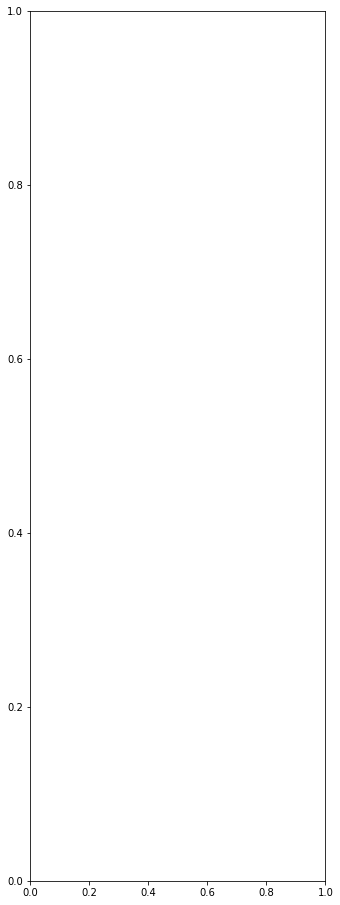

In [15]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[1]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==1)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])

### Ambiguous Images for task 2

In [ ]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[2]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==2)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])

### Ambiguous Images for task 3

In [ ]:
idx = pd.IndexSlice
ambiguous = grouped.loc[idx[[3]], (grouped>=4)&(grouped<=6)].index
ambiguous = list(set([y for (x,y,z) in ambiguous]))
list_of_files = list(set(df[(df.task==3)&(df.id_image.isin(ambiguous))]['image name']))
list_of_files = [os.path.join(imagespath, x) for x in list_of_files]
for idx2 in range(0,len(list_of_files),3):
    showImagesHorizontally(list_of_files[idx2:idx2+3])